In [1]:
import os
os.system('clear')

import torch 
from hf_ar.model import GPTModelCIFAR
from transformers import GPT2Config, GPT2PreTrainedModel, LogitsProcessorList, LogitsWarper, GPT2LMHeadModel
import einops
from ar_inference import GPT2InferenceModel
import matplotlib.pyplot as plt


from vqvae import VQVAE

vq_ckpt_path = '/home/ubuntu/VQVAE/vq-vae-2-pytorch/checkpoint/vqvae_073.pt'
vqvae   = VQVAE()

vqvae.load_state_dict(torch.load(vq_ckpt_path))


from dataset import LMDBDataset
datset_path = '/home/ubuntu/VQVAE/vq-vae-2-pytorch/exp1'
dataset = LMDBDataset(datset_path)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True
)

batch = next(iter(loader))

model = GPTModelCIFAR(heads=16, layers=8)
model_ckpt= '/home/ubuntu/VQVAE/vq-vae-2-pytorch/hf_ar/ckpt/model_11.pth'
model.load_state_dict(torch.load(model_ckpt))

/home/ubuntu/anaconda3/envs/scribeaudio/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [2]:
top, bottom, class_label = batch
top          = einops.rearrange(top, 'b h w -> b (h w)')
bottom       = einops.rearrange(bottom, 'b h w -> b (h w)') 

top_index       = top.size(-1) 
bottom_index    = bottom.size(-1) 

fake_input = torch.ones((1,29)).long()


emb = torch.cat((top,bottom), dim = -1)
emb_orig = emb
emb = emb[0][:10].unsqueeze(0)
emb, fake_input

class_label


tensor([[9],
        [3],
        [9],
        [5]])

In [9]:
logits_processor = LogitsProcessorList()
model.gpt.wte = model.embedding
inference_model = GPT2InferenceModel(
    model.gpt_config,
    model.gpt,
    model.wpe,
    model.embedding,
    model.final_norm,
    model.head
    )

class_label = torch.tensor([[9],
        [8],
        [7],
        [6],
        [5],
        [4],
        [3],
        [2],
        [1],
        [0]])
print(class_label.size())
class_emb = model.class_embedding(class_label)

class_emb = class_emb[2]
inference_model.store_emb(class_emb)


logits_processor = LogitsProcessorList()


inputs = torch.ones((1,2)).long()
gen = inference_model.generate(inputs, bos_token_id=1024, pad_token_id=1025, eos_token_id=1025,
                                max_length=83, logits_processor=logits_processor,
                                num_return_sequences=1, temperature=0.65, top_p=0.9)
gen.size()

torch.Size([10, 1])


torch.Size([1, 82])

torch.Size([1, 83])

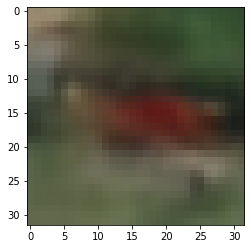

In [10]:
gen_ = gen[:,1:-1]

t_codes = gen_[:,:16].reshape(1,4,4)
t_codes.size()

b_codes = gen_[:,16:80].reshape(1,8,8) - 512
b_codes.size()

dec = vqvae.decode_code(t_codes, b_codes)
dec = dec.permute(0,2,3,1)
dec.size()

plt.imshow(dec.squeeze().detach().cpu().numpy())

tensor([[[-496, -496, -496, -496, -496, -496, -496, -496],
         [-496,    3,  120,  120,  151,  120,  120,   26],
         [ 120,  120,  151,  151,  151,  120,  120,   26],
         [ 120,  120,  151,  210,  151,  120,  120,   26],
         [ 120,  120,  151,  120,  120,  120,  120,   26],
         [ 120,  120,  151,  120,  151,  120,  151,  120],
         [ 120,  120,  151,  120,  151,  120,  151,   26],
         [ 120,  120,  151,  120,  120,  120,  120,   26]]])

In [71]:
t_codes

tensor([[[ 1, 19, 19, 19],
         [19, 27, 19, 19],
         [19, 19, 19, 19],
         [19, 19, 19, 19]]])

In [106]:

class_label.size()

torch.Size([1, 1])